<a href="https://www.kaggle.com/code/yorkyong/aspect-based-sentiment-analysis-llama-ft?scriptVersionId=201438938" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
#with reference from https://www.kaggle.com/code/lucamassaron/fine-tune-llama-2-for-sentiment-analysis

In [5]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import re
import os
from tqdm import tqdm
import bitsandbytes as bnb
from collections import defaultdict
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [9]:
pd.set_option('display.max_colwidth', None)  # Show full width of each column

In [10]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.4.0


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


# Preparing the data and the core evaluation functions

In [12]:
filename= '/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/cleaned_data_ABSA_col.xlsx'

In [13]:
df = pd.read_excel(filename)

In [14]:
df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,Food,Service,Cleanliness,Price,Others
0,"1044 US-11, Champlain, NY 12919, United States",12919,11931,6 months ago,negative,Food seems to be getting worse. Tables dirty. Sketchy crowd loitering within the store.,food seems getting worse table dirty sketchy crowd loitering within store,1,0,1,0,1
1,"1044 US-11, Champlain, NY 12919, United States",12919,11895,a week ago,negative,Food was slow. Manager (short hair woman) was having a mental breakdown or something and was being rude. She needs to be fired. Her name was Elizabeth or something. Very unprofessional.,food slow manager short hair woman mental breakdown something rude need fired name elizabeth something unprofessional,1,1,0,0,1
2,"1044 US-11, Champlain, NY 12919, United States",12919,11920,a month ago,negative,Franchise owners need to hire more staff to keep up with demand,franchise owner need hire staff keep demand,0,1,0,0,1
3,"1044 US-11, Champlain, NY 12919, United States",12919,11912,2 weeks ago,negative,Haven't seen a McDonald's so lost in my life :(,seen lost life,0,0,0,0,1
4,"1044 US-11, Champlain, NY 12919, United States",12919,11897,4 months ago,negative,"I came there to pick up order around 5 in the morning, there was a manager(brown hair) who dealt with me very rudely, i politely requested for my uber pick up but he showed me attitude and just shut the window. That was an awful experience for me and i would like to suggest them to show some etiquettes and respect towards their customers. I also work in a restaurant and know how to deal with the customers and uber orders.",came pick order around morning managerbrown hair dealt rudely politely requested uber pick showed attitude shut window awful experience would like suggest show etiquette respect towards customer also work restaurant know deal customer uber order,0,1,0,0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   store_address       2532 non-null   object
 1   location            2532 non-null   int64 
 2   reviewer_id         2532 non-null   int64 
 3   review_time         2532 non-null   object
 4   actual_sentiment    2532 non-null   object
 5   review              2532 non-null   object
 6   token_review_clean  2532 non-null   object
 7   Food                2532 non-null   int64 
 8   Service             2532 non-null   int64 
 9   Cleanliness         2532 non-null   int64 
 10  Price               2532 non-null   int64 
 11  Others              2532 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 237.5+ KB


# Train Test Split with Stratification by Actual Sentiment

In [16]:
X_train = []
X_test = []
X_eval = []

# Iterate through the unique sentiments to split data into train, test, and eval
for sentiment in ["positive", "neutral", "negative"]:
    # Split into train and test
    train, test = train_test_split(
        df[df.actual_sentiment == sentiment], test_size=0.3, random_state=42
    )
    
    # Split remaining data for evaluation
    test, eval_split = train_test_split(test, test_size=0.5, random_state=42)
    
    # Append to respective lists
    X_train.append(train)
    X_test.append(test)
    X_eval.append(eval_split)

# Concatenate the results
X_train = pd.concat(X_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
X_eval = pd.concat(X_eval).reset_index(drop=True)

In [17]:
print(f"The train set for modelling has {len(X_train)} rows.")
print(f"The test set for modelling has {len(X_test)} rows.")
print(f"The eval set for modelling has {len(X_eval)} rows.")

The train set for modelling has 1771 rows.
The test set for modelling has 380 rows.
The eval set for modelling has 381 rows.


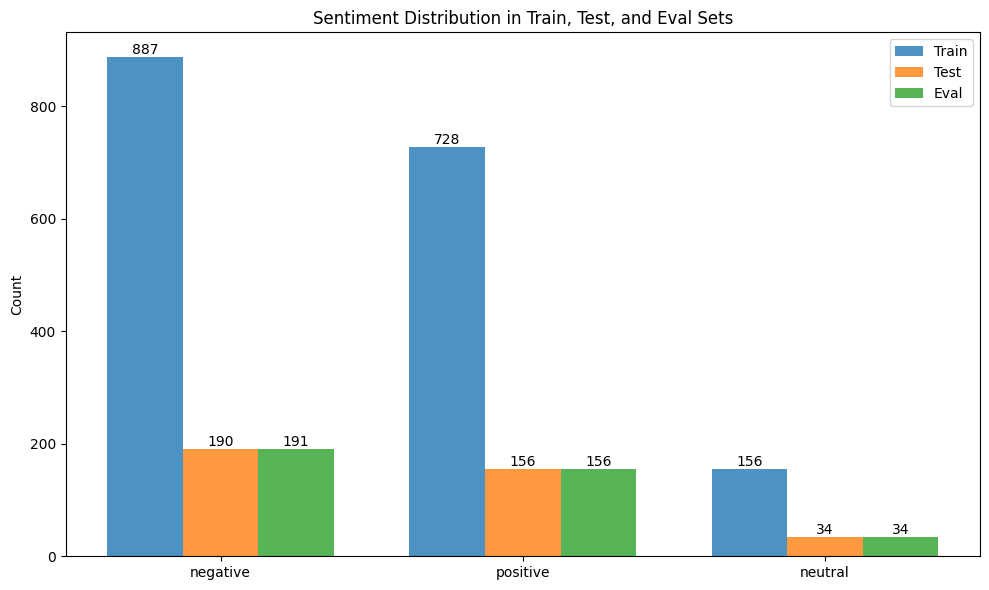

In [18]:
import matplotlib.pyplot as plt

def plot_sentiment_distribution(X_train, X_test, X_eval):
    # Count sentiments in train, test, and eval sets
    train_counts = X_train['actual_sentiment'].value_counts()
    test_counts = X_test['actual_sentiment'].value_counts()
    eval_counts = X_eval['actual_sentiment'].value_counts()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars
    x = range(len(train_counts))
    width = 0.25  # Adjust width for three groups
    ax.bar([i - width for i in x], train_counts.values, width, label='Train', alpha=0.8)
    ax.bar([i for i in x], test_counts.values, width, label='Test', alpha=0.8)
    ax.bar([i + width for i in x], eval_counts.values, width, label='Eval', alpha=0.8)

    # Customize the plot
    ax.set_ylabel('Count')
    ax.set_title('Sentiment Distribution in Train, Test, and Eval Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(train_counts.index)
    ax.legend()

    # Add value labels on top of each bar for Train, Test, and Eval
    for i, v in enumerate(train_counts.values):
        ax.text(i - width, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(test_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(eval_counts.values):
        ax.text(i + width, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_sentiment_distribution(X_train, X_test, X_eval)

# Prompt

In [19]:
def generate_prompt(row):
    aspects = ["Food", "Service", "Cleanliness", "Price", "Others"]
    scores = {aspect: row[aspect] for aspect in aspects}
    
    return f"""
Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.
For each aspect, assign a sentiment score based on the following scale:
0: Aspect is not mentioned or cannot be inferred
1: Negative sentiment
2: Neutral sentiment
3: Positive sentiment
IMPORTANT:
- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.
- If an aspect is not mentioned or cannot be directly inferred, keep its score as 0.
- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.
- Provide ONLY the scores in the exact format shown below, with no additional text or explanations.
Provide your analysis in the following format ONLY:
Food=[score]
Service=[score]
Cleanliness=[score]
Price=[score]
Others=[score]
Review: {row['review']}
Analysis:
Food={scores['Food']}
Service={scores['Service']}
Cleanliness={scores['Cleanliness']}
Price={scores['Price']}
Others={scores['Others']}
""".strip()

def generate_test_prompt(row):
    return f"""
Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.
For each aspect, assign a sentiment score based on the following scale:
0: Aspect is not mentioned or cannot be inferred
1: Negative sentiment
2: Neutral sentiment
3: Positive sentiment
IMPORTANT:
- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.
- If an aspect is not mentioned or cannot be directly inferred, assign it a score of 0.
- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.
- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.
- Do not continue with unrelated reviews or add any content beyond the requested format.
- Interpret the review accurately, considering both explicit mentions and strong implications.
Provide your analysis in the following format ONLY:
Food=X Service=X Cleanliness=X Price=X Others=X
Where X is the score (0, 1, 2, or 3) for each aspect.
Review: {row['review']}
Analysis:
""".strip()

In [20]:
# Generate the full prompt (input) for training and evaluation data
X_train['prompt'] = X_train.apply(generate_prompt, axis=1)
X_eval['prompt'] = X_eval.apply(generate_prompt, axis=1)

# Select the necessary columns for training and evaluation
X_train = X_train[['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others']]
X_eval = X_eval[['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others']]

# Prepare the true labels for evaluation
y_true = X_test[['Food', 'Service', 'Cleanliness', 'Price', 'Others']]

# For X_test, generate the test prompt without sentiment scores
X_test['prompt'] = X_test.apply(generate_test_prompt, axis=1)
X_test = X_test[['review', 'prompt']]

# Convert the DataFrames to datasets
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
test_data = Dataset.from_pandas(X_test)

In [21]:
train_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 1771
})

In [22]:
eval_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 381
})

In [23]:
X_test

,review,prompt
0,Wonderful staff. Very accommodating. Food was made quick and well,"Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n0: Aspect is not mentioned or cannot be inferred\n1: Negative sentiment\n2: Neutral sentiment\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or cannot be directly inferred, assign it a score of 0.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (0, 1, 2, or 3) for each aspect.\nReview: Wonderful staff. Very accommodating. Food was made quick and well\nAnalysis:"
1,Yum,"Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n0: Aspect is not mentioned or cannot be inferred\n1: Negative sentiment\n2: Neutral sentiment\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or cannot be directly inferred, assign it a score of 0.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (0, 1, 2, or 3) for each aspect.\nReview: Yum\nAnalysis:"
2,"Very busy site, a clean as it could be,","Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n0: Aspect is not mentioned or cannot be inferred\n1: Negative sentiment\n2: Neutral sentiment\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or cannot be directly inferred, assign it a score of 0.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (0, 1, 2, or 3) for each aspect.\nReview: Very busy site, a clean as it could be,\nAnalysis:"
3,I came right at closing time and the manager took my order then when I got to the first window I was told sorry we are closed. I told him someone repeated my order and went to ask at the same time the manager came to the first window after telling his coworker the situation the manager hurry and got payment then hurried back to round up my order while everyone else was getting ready to leave he the

# Create Evaluation Function

In [24]:
def evaluate(y_true, y_pred):
    aspects = ['Food', 'Service', 'Cleanliness', 'Price', 'Others']
    
    overall_accuracy = 0
    summary = {}
    
    for aspect in aspects:
        y_true_scores = y_true[aspect].tolist()
        y_pred_scores = y_pred[aspect].tolist()
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true_scores, y_pred_scores)
        overall_accuracy += accuracy
        
        # Generate classification report
        class_report = classification_report(y_true_scores, y_pred_scores, 
                                             labels=[0, 1, 2, 3],
                                             target_names=['Not Mentioned', 'Negative', 'Neutral', 'Positive'],
                                             zero_division=0)
        
        # Generate confusion matrix
        conf_matrix = confusion_matrix(y_true_scores, y_pred_scores, labels=[0, 1, 2, 3])
        
        # Print results
        print(f"\nEvaluation for {aspect.capitalize()}:")
        print("Sample data (first 10 pairs):")
        for i in range(min(10, len(y_true_scores))):
            print(f"  True: {y_true_scores[i]}, Pred: {y_pred_scores[i]}")
        
        print(f"\nAccuracy: {accuracy:.3f}")
        
        print("\nClassification Report:")
        print(class_report)
        
        print("Confusion Matrix:")
        print(conf_matrix)
        print("-----------------------------------------------------------")
        
        # Store summary for this aspect
        summary[aspect] = {
            'accuracy': accuracy,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix.tolist()
        }
    
    overall_accuracy = overall_accuracy / len(aspects)
    print(f"\nOverall Accuracy: {overall_accuracy:.3f}")
    summary['overall_accuracy'] = overall_accuracy
    
    return summary

# Testing model without fine-tuning

In [ ]:
# # For clearing GPU memory
# import gc

# del [
#     model, 
#     tokenizer, 
# ]
# # del [df, X_train, X_eval]

In [ ]:
# for _ in range(100):
#     torch.cuda.empty_cache()
#     gc.collect()

In [25]:
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
# model_name = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
# model_name = "/kaggle/input/llama-3.1/transformers/405b-instruct/1"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
print(len(tokenizer))  # Check vocabulary size

128258


In [27]:
def predict(df_data, model, tokenizer, debug=False):
    aspects = ['Food', 'Service', 'Cleanliness', 'Price', 'Others']
    y_pred = []
    
    for i in tqdm(range(len(df_data))):
        row = df_data.iloc[i]
        prompt = row['prompt']
        review = row['review']
        
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=20,
                        temperature=0.1)
        try:
            result = pipe(prompt)
            generated_text = result[0]['generated_text']
            
            # Extract only the part that matches our expected format
            answer = re.search(r'Analysis:[\s\S]*', generated_text)
            if answer:
                answer = answer.group(0)
            else:
                raise ValueError("Unexpected output format")
            
            # Initialize a dictionary to store scores for all aspects
            scores = {aspect: 0 for aspect in aspects}
            
            # Extract scores for all aspects
            for aspect in aspects:
                # Match both =X and =[X] formats
                match = re.search(rf'{aspect}=(\[?)(\d)(\]?)', answer, re.IGNORECASE)
                if match:
                    score = int(match.group(2))
                    if 0 <= score <= 3:
                        scores[aspect] = score
            
            y_pred.append(scores)
            
            if debug:
                print(f"\nItem {i}:")
                print(f"Review: {review}")
                print(f"Generated: {answer.strip()}")
                print(f"Parsed sentiments: {scores}")
        
        except Exception as e:
            print(f"Error processing item {i}: {str(e)}")
            y_pred.append({aspect: 0 for aspect in aspects})
    
    # Convert the list of dictionaries to a DataFrame
    df_pred = pd.DataFrame(y_pred)
    
    return df_pred

In [69]:
y_pred = predict(X_test, model, tokenizer, debug=False)

100%|██████████| 380/380 [20:43<00:00,  3.27s/it]


In [70]:
evaluate(y_true, y_pred)


Evaluation for Food:
Sample data (first 10 pairs):
  True: 3, Pred: 3
  True: 3, Pred: 0
  True: 0, Pred: 0
  True: 3, Pred: 0
  True: 3, Pred: 3
  True: 0, Pred: 0
  True: 0, Pred: 0
  True: 0, Pred: 3
  True: 3, Pred: 3
  True: 3, Pred: 3

Accuracy: 0.805

Classification Report:
               precision    recall  f1-score   support

Not Mentioned       0.95      0.78      0.86       277
     Negative       0.65      0.89      0.75        44
      Neutral       1.00      0.20      0.33         5
     Positive       0.54      0.91      0.68        54

     accuracy                           0.81       380
    macro avg       0.79      0.69      0.65       380
 weighted avg       0.86      0.81      0.81       380

Confusion Matrix:
[[217  19   0  41]
 [  5  39   0   0]
 [  1   2   1   1]
 [  5   0   0  49]]
-----------------------------------------------------------

Evaluation for Service:
Sample data (first 10 pairs):
  True: 3, Pred: 3
  True: 0, Pred: 0
  True: 0, Pred: 0
  True:

{'Food': {'accuracy': 0.8052631578947368,
  'classification_report': '               precision    recall  f1-score   support\n\nNot Mentioned       0.95      0.78      0.86       277\n     Negative       0.65      0.89      0.75        44\n      Neutral       1.00      0.20      0.33         5\n     Positive       0.54      0.91      0.68        54\n\n     accuracy                           0.81       380\n    macro avg       0.79      0.69      0.65       380\n weighted avg       0.86      0.81      0.81       380\n',
  'confusion_matrix': [[217, 19, 0, 41],
   [5, 39, 0, 0],
   [1, 2, 1, 1],
   [5, 0, 0, 49]]},
 'Service': {'accuracy': 0.7894736842105263,
  'classification_report': '               precision    recall  f1-score   support\n\nNot Mentioned       0.87      0.69      0.77       182\n     Negative       0.87      0.92      0.89       134\n      Neutral       0.00      0.00      0.00         3\n     Positive       0.55      0.85      0.67        61\n\n     accuracy         

# FineTuning

In [28]:
eval_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 381
})

In [29]:
train_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 1771
})

In [30]:
output_dir="trained_weigths"
peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules=["q_proj", "v_proj"],  # Specify exact linear layers (adjust based on model architecture)
        task_type="CAUSAL_LM",
        use_dora=True
)
training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=16,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,                             # max step as -1 to use all epochs
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
#     report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="steps",  # Change to "steps" instead of "epoch"
    eval_steps=30,  # Evaluate every 30 steps instead of every epoch
)
    
    
    
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,  # Reduced from 1024 to save memory
    max_seq_length=512, # Enable packing to optimize memory usage
    packing=True,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api")
import wandb
! wandb login $wandb_key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: yorkyong-yeo (yorkyong). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
30,0.894600,0.588467


TrainOutput(global_step=54, training_loss=0.6900595779772158, metrics={'train_runtime': 4506.525, 'train_samples_per_second': 0.194, 'train_steps_per_second': 0.012, 'total_flos': 1.999244932153344e+16, 'train_loss': 0.6900595779772158, 'epoch': 0.9874285714285714})

In [33]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.json')

# Clean up memory

In [ ]:
import gc

del [
    model, 
     tokenizer, 
     peft_config, 
    trainer, 
    train_data, 
    eval_data, 
    bnb_config, 
    training_arguments
]
# del [df, X_train, X_eval]
del [
    TrainingArguments, 
    SFTTrainer, 
    LoraConfig, 
    BitsAndBytesConfig
]

In [ ]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
!nvidia-smi

# Load weights to model for testing

In [ ]:
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify model name and path
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
peft_model_id = "/kaggle/working/trained_weigths"
# peft_model_id = "/kaggle/input/sentiment-analysis-with-llama-3-1/trained_weigths"

In [ ]:
# Set computation dtype
compute_dtype = getattr(torch, "float16")

# Configure bits and bytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True
)

# Load the base model with CPU offloading
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

In [ ]:
print(len(tokenizer))

In [ ]:
# Load the PEFT adapter
model.load_adapter(peft_model_id)

# Configure model settings
model.config.use_cache = False
model.config.pretraining_tp = 1

# Ensure the model is in evaluation mode
model.eval()

print("Model and tokenizer loaded successfully.")

In [ ]:
y_pred = predict(X_test, model, tokenizer, debug=False)

In [ ]:
evaluate(y_true, y_pred)